In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import linear_model

from sklearn import preprocessing

from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Getting a list of NaN valued cols
train.isnull().sum()[train.isnull().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [5]:
numeric_cols = list(train.select_dtypes(exclude=["object"]).columns)
del numeric_cols[:-1]
numeric_cols

['SalePrice']

In [6]:
train["FinishedArea"] = train["TotalBsmtSF"] - train["BsmtUnfSF"]

In [7]:
cor_dict = dict(train.corr()["SalePrice"] > 0.5)
train[[i for i in cor_dict if cor_dict[i] == True]].corr()

,GrLivArea,GarageCars,GarageArea,FullBath,SalePrice,TotRmsAbvGrd,TotalBsmtSF,YearBuilt,OverallQual,1stFlrSF,YearRemodAdd
GrLivArea,1.000000,0.467247,0.468997,0.630012,0.708624,0.825489,0.454868,0.199010,0.593007,0.566024,0.287389
GarageCars,0.467247,1.000000,0.882475,0.469672,0.640409,0.362289,0.434585,0.537850,0.600671,0.439317,0.420622
GarageArea,0.468997,0.882475,1.000000,0.405656,0.623431,0.337822,0.486665,0.478954,0.562022,0.489782,0.371600
FullBath,0.630012,0.469672,0.405656,1.000000,0.560664,0.554784,0.323722,0.468271,0.550600,0.380637,0.439046
SalePrice,0.708624,0.640409,0.623431,0.560664,1.000000,0.533723,0.613581,0.522897,0.790982,0.605852,0.507101
TotRmsAbvGrd,0.825489,0.362289,0.337822,0.554784,0.533723,1.000000,0.285573,0.095589,0.427452,0.409516,0.191740
TotalBsmtSF,0.454868,0.434585,0.486665,0.323722,0.613581,0.285573,1.000000,0.391452,0.537808,0.819530,0.291066
YearBuilt,0.199010,0.537850,0.478954,0.468271,0.522897,0.095589,0.391452,1.000000,0.572323,0.281986,0.592855
OverallQual,0.593007,0.600671,0.562022,0.550600,0.790982,0.427452,0.537808,0.572323,1.000000,0.476224,0.550684
1stFlrSF,0.566024,0.439317,0.489782,0.380637,0.605852,0.409516,0.819530,0.281986,0.476224,1.000000,0.240379


In [8]:
def text_to_num(train, ls_to_norm):
    ls_x_map = []
    for i in ls_to_norm:
        gr_by = train["SalePrice"].groupby(train[i])
        x_map = gr_by.mean() / gr_by.mean().max()
        train[i + "_num"] = train[i].map(x_map)
        ls_x_map.append(x_map)
    return train, ls_x_map

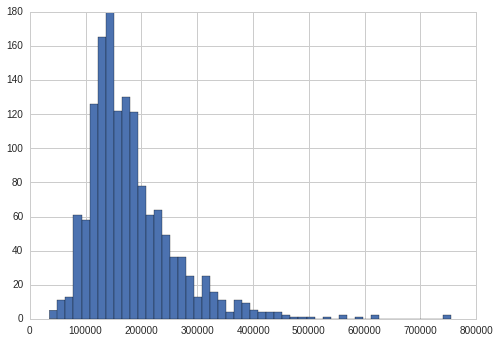

In [9]:
with sns.axes_style("whitegrid"):
    train.SalePrice.hist(bins=50)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


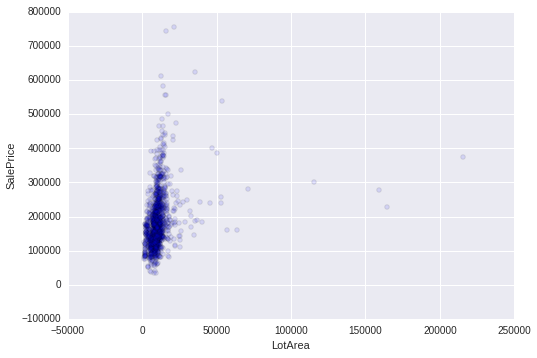

In [10]:
#train = train[train["LotArea"] < 50000]

feat = "LotArea"
def scat(train_2std, feat, res):
    plt.scatter(train_2std[feat], train_2std[res], lw=1, alpha=.1)
    plt.xlabel(feat)
    plt.ylabel(res)
        
scat(train, feat, "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


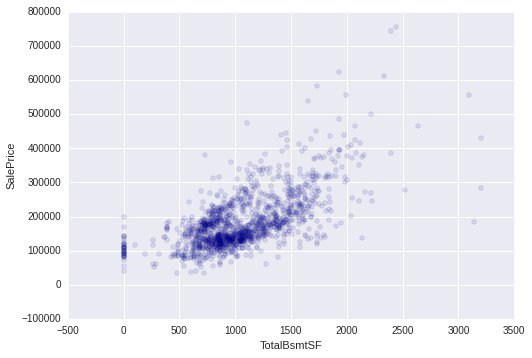

In [11]:
train = train[train["TotalBsmtSF"] < 6000]
scat(train, "TotalBsmtSF", "SalePrice")


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


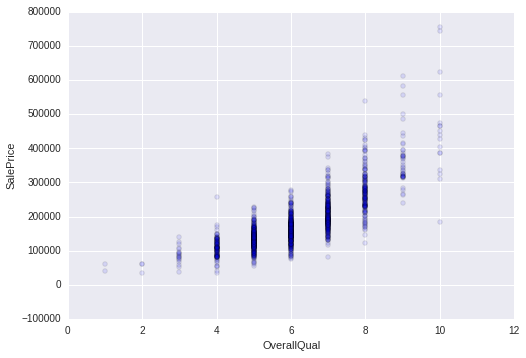

In [12]:
scat(train, "OverallQual", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


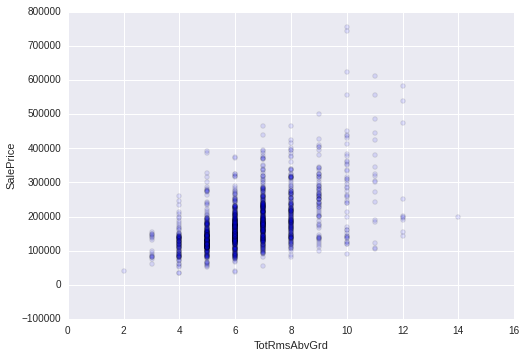

In [13]:
scat(train, "TotRmsAbvGrd", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


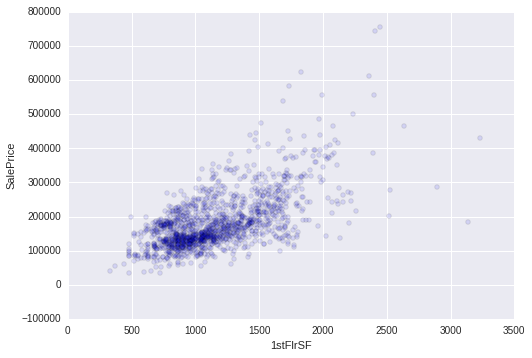

In [14]:
scat(train, "1stFlrSF", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


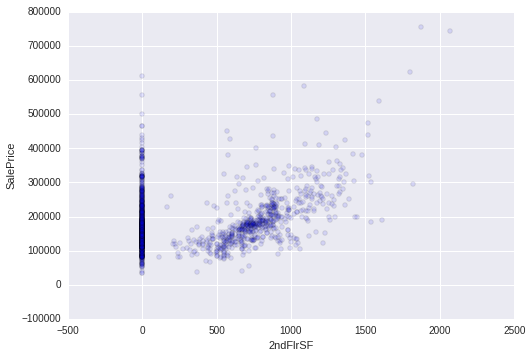

In [15]:
scat(train, "2ndFlrSF", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


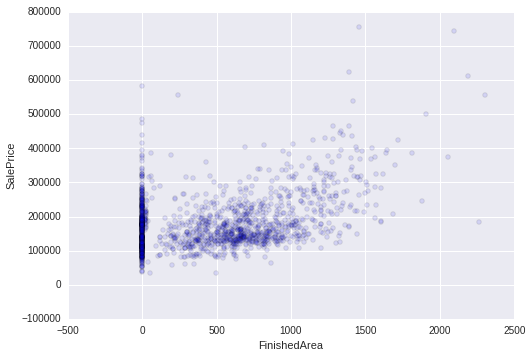

In [16]:
scat(train, "FinishedArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


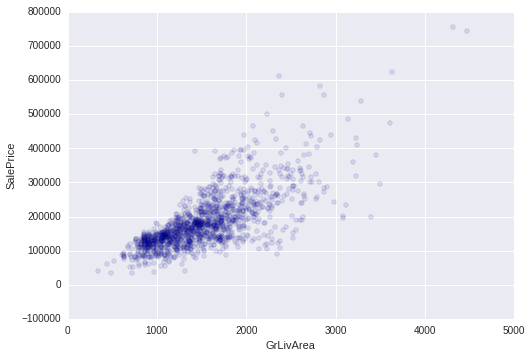

In [17]:
train = train[train["GrLivArea"] < 4600]
scat(train, "GrLivArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


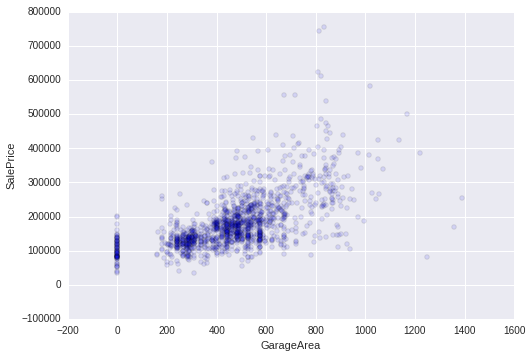

In [18]:
scat(train, "GarageArea", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


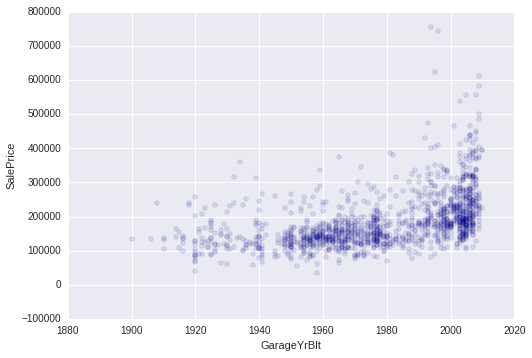

In [19]:
scat(train, "GarageYrBlt", "SalePrice")

In [20]:
train["QualYear"] = train["OverallQual"] / train["YearBuilt"]

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


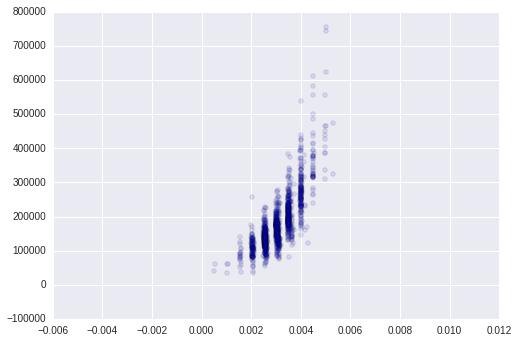

In [21]:
plt.scatter(train["OverallQual"] / train["YearBuilt"], train["SalePrice"], lw=1, alpha=.1)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


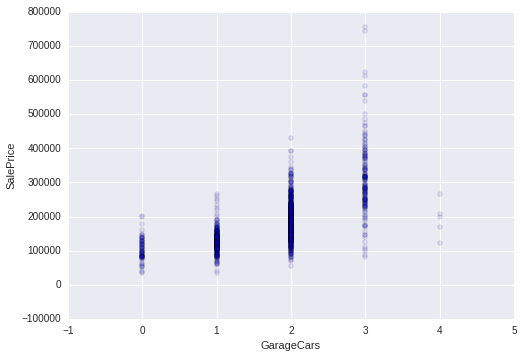

In [22]:
scat(train, "GarageCars", "SalePrice")

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


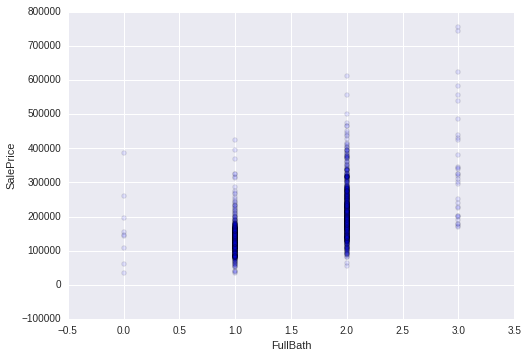

In [23]:
scat(train, "FullBath", "SalePrice")

In [24]:
#Prepping data for linear regression
test = pd.read_csv("test.csv")
"""
test["MSZoning_norm"] = test["MSZoning"].map(ls_map[0])
test["Neighborhood_norm"] = test["Neighborhood"].map(ls_map[1])
test["ExterQual_norm"] = test["ExterQual"].map(ls_map[2])
test["ExterCond_norm"] = test["ExterCond"].map(ls_map[3])
"""
#ls_params = ["LotArea", "OverallQual", "TotRmsAbvGrd", "GarageArea", 
#            "1stFlrSF", "2ndFlrSF", "YearBuilt", "FinishedArea", "PoolArea",  "GrLivArea"]

#ls_params = numeric_cols
#kernel
ls_params =["LotArea","TotalBsmtSF", "OverallQual", "TotRmsAbvGrd", "GarageArea",
             "1stFlrSF", "2ndFlrSF", "YearBuilt", "YearRemodAdd", "GrLivArea", "GarageYrBlt"]

test["FinishedArea"] = test["TotalBsmtSF"] - test["BsmtUnfSF"]

test["QualYear"] = test["OverallQual"] / test["YearBuilt"]

test_X = test[ls_params].fillna(0)

train_X = train[ls_params].fillna(0)
train_Y = train["SalePrice"]

In [25]:
test_X.isnull().sum()[test_X.isnull().sum() > 0]

Series([], dtype: int64)

In [26]:
linreg = linear_model.LinearRegression()

In [27]:
linreg.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
pred_Y = linreg.predict(test_X)

In [29]:
linreg.score(train_X, train_Y)

0.82818764532181655

In [30]:
scores = cross_val_score(linreg, train_X, train_Y, cv=10)
scores

array([ 0.80882239,  0.82601059,  0.86709093,  0.85393492,  0.81819032,
        0.8241289 ,  0.77913182,  0.79737634,  0.80057926,  0.82143787])

In [31]:
ridgereg = linear_model.Ridge(alpha=0.1)
ridgereg.fit(train_X, train_Y)
pred_Y_ridge = ridgereg.predict(test_X)
ridgereg.score(train_X, train_Y)

0.82818764497313035

In [32]:
scores_ridge = cross_val_score(ridgereg, train_X, train_Y, cv=10)
scores_ridge

array([ 0.80882292,  0.82600901,  0.86709133,  0.85393563,  0.81819012,
        0.82413134,  0.77913231,  0.79737927,  0.80057613,  0.82143844])

In [33]:
lasso = linear_model.LassoCV(alphas = [0.01, 0.1, 10], cv=10)
lasso.fit(train_X, train_Y)
pred_Y_lasso = lasso.predict(test_X)
lasso.score(train_X, train_Y)

/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.82818760598073637

In [34]:
scores_ridge = cross_val_score(lasso, train_X, train_Y, cv=10)
scores_ridge

/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/vanya/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You migh

array([ 0.80881907,  0.82603438,  0.86708944,  0.85393493,  0.81818324,
        0.82412901,  0.77915202,  0.79737652,  0.80057932,  0.82143791])

In [35]:
df_out = pd.DataFrame({"Id":test["Id"], "SalePrice":pred_Y})

In [36]:
df_out.to_csv("withoutcleaningQY.csv", index=False)

In [37]:
pred_Y_res = linreg.predict(train_X)

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


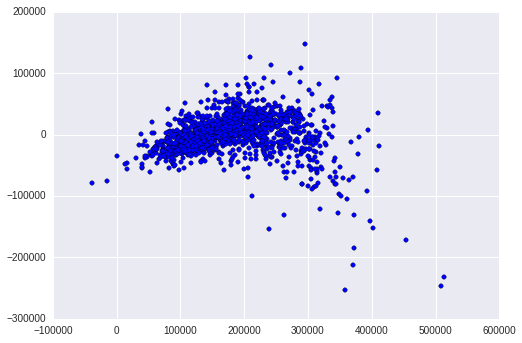

In [38]:
plt.scatter(pred_Y_res, pred_Y_res - train_Y)

In [39]:
#df_out_ringe = pd.DataFrame({"Id":test["Id"], "SalePrice":pred_Y_ridge})
#df_out_ringe.to_csv("ringed.csv", index=False)

In [40]:
pred_Y_lasso[pred_Y_lasso < 0] = 0
df_out_lasso = pd.DataFrame({"Id":test["Id"], "SalePrice":pred_Y_lasso})
df_out_lasso.to_csv("lasso.csv", index=False)

(array([  64.,  426.,  484.,  320.,  130.,   30.,    4.,    0.,    0.,    1.]),
 array([      0.        ,   68448.69125681,  136897.38251362,
         205346.07377043,  273794.76502724,  342243.45628405,
         410692.14754086,  479140.83879767,  547589.53005448,
         616038.22131129,  684486.91256809]),
 <a list of 10 Patch objects>)

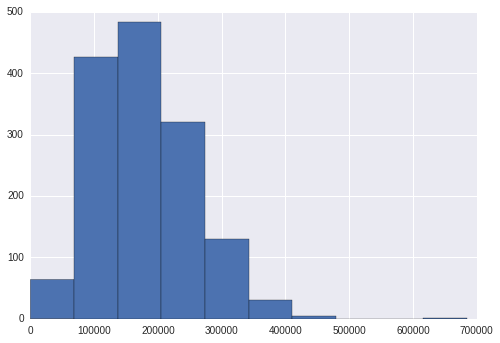

In [41]:
#pred_Y_lasso_res = lasso.predict(train_X)
plt.hist(pred_Y_lasso)